#Load Dataset

In [1]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 11.8 MB/s eta 0:00:00


In [2]:
import patoolib
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path = '/content/drive/My Drive/raw_data.zip'
extraction_dir = '/content/'

In [5]:
# Unzipping
patoolib.extract_archive(zip_file_path, outdir=extraction_dir)

print(f"Unzipped data to: {extraction_dir}")

INFO patool: Extracting /content/drive/My Drive/raw_data.zip ...
INFO:patool:Extracting /content/drive/My Drive/raw_data.zip ...
INFO patool: running /usr/bin/7z x -aou -o/content/ -- "/content/drive/My Drive/raw_data.zip"
INFO:patool:running /usr/bin/7z x -aou -o/content/ -- "/content/drive/My Drive/raw_data.zip"
INFO patool: ... /content/drive/My Drive/raw_data.zip extracted to `/content/'.
INFO:patool:... /content/drive/My Drive/raw_data.zip extracted to `/content/'.


Unzipped data to: /content/


# Basic Model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

##Create train datasets

In [2]:
data_dir = os.path.join(os.getcwd(),'raw_data')

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14925 files belonging to 5 classes.
Using 11940 files for training.


## Create validation datasets

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14925 files belonging to 5 classes.
Using 2985 files for validation.


## Create test datasets

In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [5]:
class_names = train_ds.class_names
print(class_names)

['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
num_classes = len(class_names)

model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 510s 333ms/step - accuracy: 0.4973 - loss: 1.2165 - val_accuracy: 0.6928 - val_loss: 0.8061
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7229 - loss: 0.7338 - val_accuracy: 0.7090 - val_loss: 0.7389
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7901 - loss: 0.5571 - val_accuracy: 0.7273 - val_loss: 0.7173
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8331 - loss: 0.4426 - val_accuracy: 0.7410 - val_loss: 0.7113
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9030 - loss: 0.2791 - val_accuracy: 0.7352 - val_loss: 0.8182
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9476 - loss: 0.1572 - val_accuracy: 0.7244 - val_loss: 0.9866
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9729 - loss: 0.0900 - val_accuracy: 0.7306 - val_loss: 1.0276
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9819 - loss: 0.0611 - v

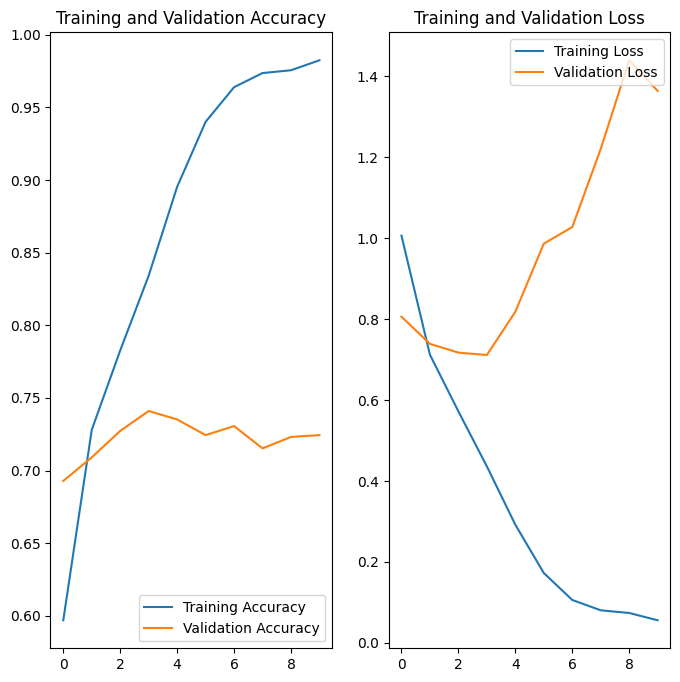

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6998 - loss: 1.6739
Test accuracy : 0.7222222089767456


# Transfer Learning using MobileNet V2

## Data Augmentation

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [17]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

<ipython-input-17-c0dbe9077ce2>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Feature Extraction

In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 90, 90, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 90, 90, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 90, 90, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 90, 90, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 90, 90, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 90, 90, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 91, 91, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 45, 45, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Add a classification head

In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [21]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [22]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile & Train

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2125 - loss: 2.3414


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.33
initial accuracy: 0.21


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.3836 - loss: 1.5890 - val_accuracy: 0.7140 - val_loss: 0.7568
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7042 - loss: 0.8008 - val_accuracy: 0.7895 - val_loss: 0.5860
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7549 - loss: 0.6679 - val_accuracy: 0.8028 - val_loss: 0.5321
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.7847 - loss: 0.5924 - val_accuracy: 0.8186 - val_loss: 0.4898
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7940 - loss: 0.5478 - val_accuracy: 0.8286 - val_loss: 0.4672
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8105 - loss: 0.5101 - val_accuracy: 0.8335 - val_loss: 0.4534
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8135 - loss: 0.5079 - val_accuracy: 0.8327 - val_loss: 0.4489
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8141 - loss: 0.5096 - 

In [30]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8287 - loss: 0.4981
Test accuracy : 0.8263888955116272


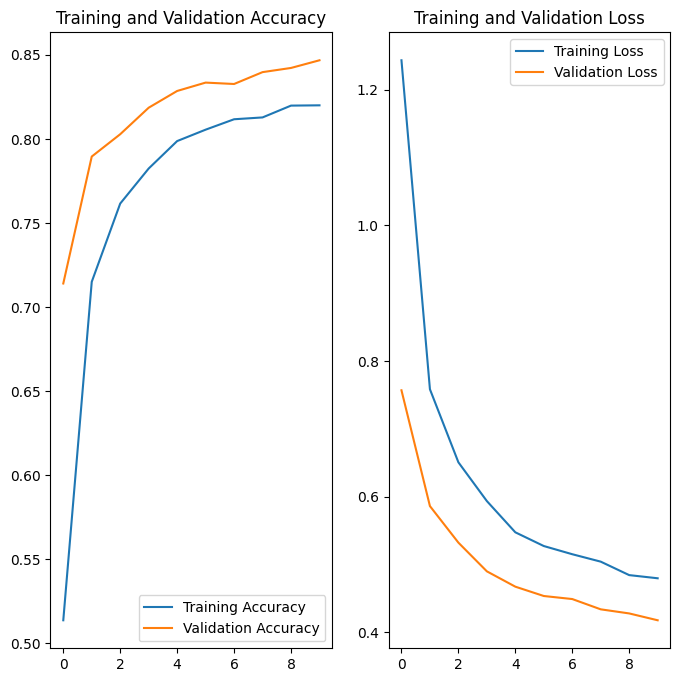

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine Tuning

In [32]:
base_model.trainable = True

In [33]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 1,867,845 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.7023 - loss: 0.7689 - val_accuracy: 0.8597 - val_loss: 0.4299
Epoch 11/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.8344 - loss: 0.4599 - val_accuracy: 0.8626 - val_loss: 0.3788
Epoch 12/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8494 - loss: 0.4039 - val_accuracy: 0.8663 - val_loss: 0.3636
Epoch 13/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.8653 - loss: 0.3678 - val_accuracy: 0.8730 - val_loss: 0.3465
Epoch 14/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8695 - loss: 0.3454 - val_accuracy: 0.8767 - val_loss: 0.3381
Epoch 15/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.8785 - loss: 0.3322 - val_accuracy: 0.8763 - val_loss: 0.3394
Epoch 16/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.8798 - loss: 0.3207 - val_accuracy: 0.8834 - val_loss: 0.3285
Epoch 17/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.8902 - loss: 0

In [40]:
acc = []
val_acc = []
loss = []
val_loss = []

acc.extend(history_fine.history['accuracy'])
val_acc.extend(history_fine.history['val_accuracy'])
loss.extend(history_fine.history['loss'])
val_loss.extend(history_fine.history['val_loss'])


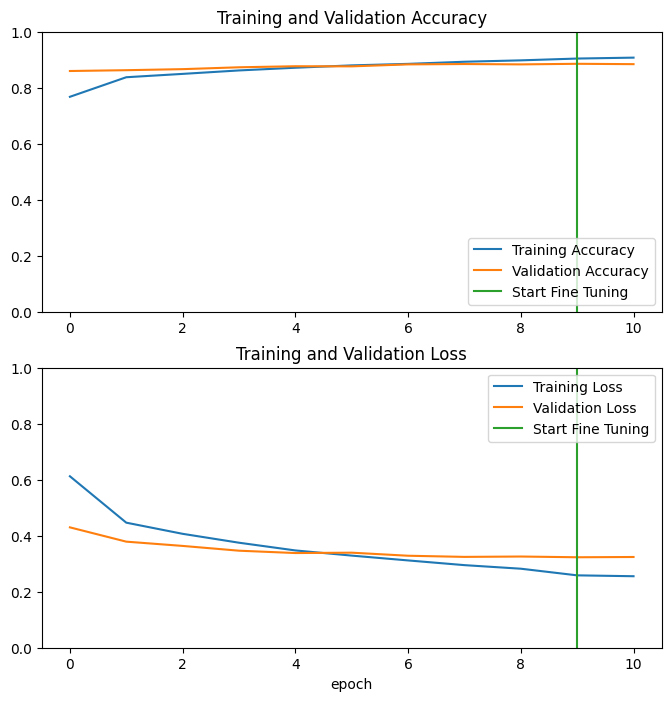

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8562 - loss: 0.4577
Test accuracy : 0.859375


In [43]:
model.save('nsfw_classification_fine_tuned.keras')

# Predict

In [44]:
from tensorflow.keras.preprocessing import image

In [45]:
def predict_image(image_path, model, img_height=180, img_width=180):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0

    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions, axis=-1)
    predicted_class_prob = np.max(predictions)

    return predicted_class, predicted_class_prob

In [58]:
image_path = 'test_image_sexy.jpg'
predicted_class, predicted_class_prob = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [59]:
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_class_prob:.4f}")

Predicted Class: [2]
Prediction Probability: 3.3280


In [ ]:
img = image.load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class} ({predicted_class_prob*100:.2f}%)")
plt.show()